## BalanceNet prototype

In [3]:
%run Setup.ipynb
%run ExtraFunctions.ipynb

[i] Loaded Parameters:
 40000 35 0.2 200 
 dataset/glove/glove.twitter.27B.200d.txt
[i] Importing Modules...


Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']
[+] Finished Importing Modules
[i] Reading from csv file...Loading from data merged...
Done!
[i] Found 58804 unique tokens.
[+] Shape of data tensor: (239953, 30)
[+] Shape of label tensor: (239953, 10)
[i] Number of entries in each category:
[+] Training:
 [    0. 18357. 78733.  9664.  4594.  3479. 20446. 26137. 24804.  5749.]
[+] Validation:
 [    0.  4577. 19842.  2365.  1146.   862.  5032.  6457.  6340.  1369.]
[i] Loading GloVe from: dataset/glove/glove.twitter.27B.200d.txt ...Done.
[+] Proceeding with Embedding Matrix...[i] Completed!
[i] Finished running setup.


In [4]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("Completed!")

Completed!


In [5]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

First Half: LSTM > CNN

In [6]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

In [7]:
l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

Second Half: CNN > LSTM

In [8]:
l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)

Combine both halfs of the model

In [9]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(4)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(10, activation='softmax')(l_dense)

In [10]:
model = Model(sequence_input, preds)
adadelta = optimizers.Adadelta(lr=0.9, rho=0.95, epsilon=None, decay=0.002)
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])

In [11]:
!rm -r logs

In [12]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [13]:
model.summary()
model.save('BalanceNet.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      11761000    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 200)      11761000    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 12)       9936        embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectio

In [14]:
#model = keras.models.load_model("checkpoint-0.902.h5")
#model = keras.models.load_model("checkpoint-0.91.h5")

In [43]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=50, batch_size=2048,
          callbacks=[tensorboard, model_checkpoints])



Training Progress:
Train on 191963 samples, validate on 47990 samples
Epoch 1/50
191963/191963 [==============================] - 146s 761us/step - loss: 1.7711 - acc: 0.4149 - val_loss: 1.6594 - val_acc: 0.4490
Epoch 2/50
191963/191963 [==============================] - 131s 682us/step - loss: 1.6058 - acc: 0.4557 - val_loss: 1.5230 - val_acc: 0.5009
Epoch 3/50
191963/191963 [==============================] - 132s 686us/step - loss: 1.5117 - acc: 0.4923 - val_loss: 1.4467 - val_acc: 0.5184
Epoch 4/50
191963/191963 [==============================] - 130s 679us/step - loss: 1.4539 - acc: 0.5109 - val_loss: 1.4196 - val_acc: 0.5285
Epoch 5/50
191963/191963 [==============================] - 131s 682us/step - loss: 1.4124 - acc: 0.5232 - val_loss: 1.3718 - val_acc: 0.5375
Epoch 6/50
191963/191963 [==============================] - 131s 684us/step - loss: 1.3837 - acc: 0.5322 - val_loss: 1.3417 - val_acc: 0.5481
Epoch 7/50
191963/191963 [==============================] - 131s 684us/step - 

In [44]:
import pandas
pandas.DataFrame(model_log.history).to_csv("history-balance.csv")

Time to train!!

## Model Testing and Inference

In [15]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ["happy", "sad", "surprise","worry", "disgust", "annoy", "joke","intrigue", "awesome"]

In [16]:
! ls

architectures	      checkpoint-1.204.h5  data.csv
BalanceNet-1.0.ipynb  checkpoint-1.208.h5  data_merged.csv
BalanceNet.h5	      checkpoint-1.214.h5  data_org.csv
checkpoint-1.151.h5   checkpoint-1.218.h5  dataset
checkpoint-1.152.h5   checkpoint-1.222.h5  experiments
checkpoint-1.156.h5   checkpoint-1.226.h5  ExtraFunctions.ipynb
checkpoint-1.158.h5   checkpoint-1.234.h5  Filter Tweets.ipynb
checkpoint-1.160.h5   checkpoint-1.250.h5  history-balance.csv
checkpoint-1.163.h5   checkpoint-1.251.h5  images
checkpoint-1.165.h5   checkpoint-1.260.h5  model.h5
checkpoint-1.166.h5   checkpoint-1.270.h5  ProcessData-Crawled.ipynb
checkpoint-1.168.h5   checkpoint-1.286.h5  ProcessData.ipynb
checkpoint-1.169.h5   checkpoint-1.295.h5  raw_data
checkpoint-1.172.h5   checkpoint-1.323.h5  README.md
checkpoint-1.173.h5   checkpoint-1.332.h5  run_tensorboard.sh
checkpoint-1.176.h5   checkpoint-1.342.h5  Setup.ipynb
checkpoint-1.177.h5   checkpoint-1.372.h5  sklearn_experiments
checkpoint-1.182.h5   ch

In [18]:
model_test = load_model('checkpoint-1.151.h5')
#model_test = load_model('best_weights.h5')
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model_test.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

In [19]:
print(set(y_pred_class))
print(classes)
print(classification_report(Y_test, y_pred_class, target_names=classes))

{1, 2, 3, 4, 5, 6, 7, 8, 9}
['happy', 'sad', 'surprise', 'worry', 'disgust', 'annoy', 'joke', 'intrigue', 'awesome']
              precision    recall  f1-score   support

       happy       0.53      0.50      0.51      4577
         sad       0.64      0.89      0.74     19842
    surprise       0.75      0.47      0.58      2365
       worry       1.00      0.55      0.71      1146
     disgust       0.96      0.03      0.06       862
       annoy       0.51      0.32      0.39      5032
        joke       0.68      0.37      0.48      6457
    intrigue       0.59      0.64      0.61      6340
     awesome       0.66      0.29      0.40      1369

   micro avg       0.63      0.63      0.63     47990
   macro avg       0.70      0.45      0.50     47990
weighted avg       0.64      0.63      0.60     47990



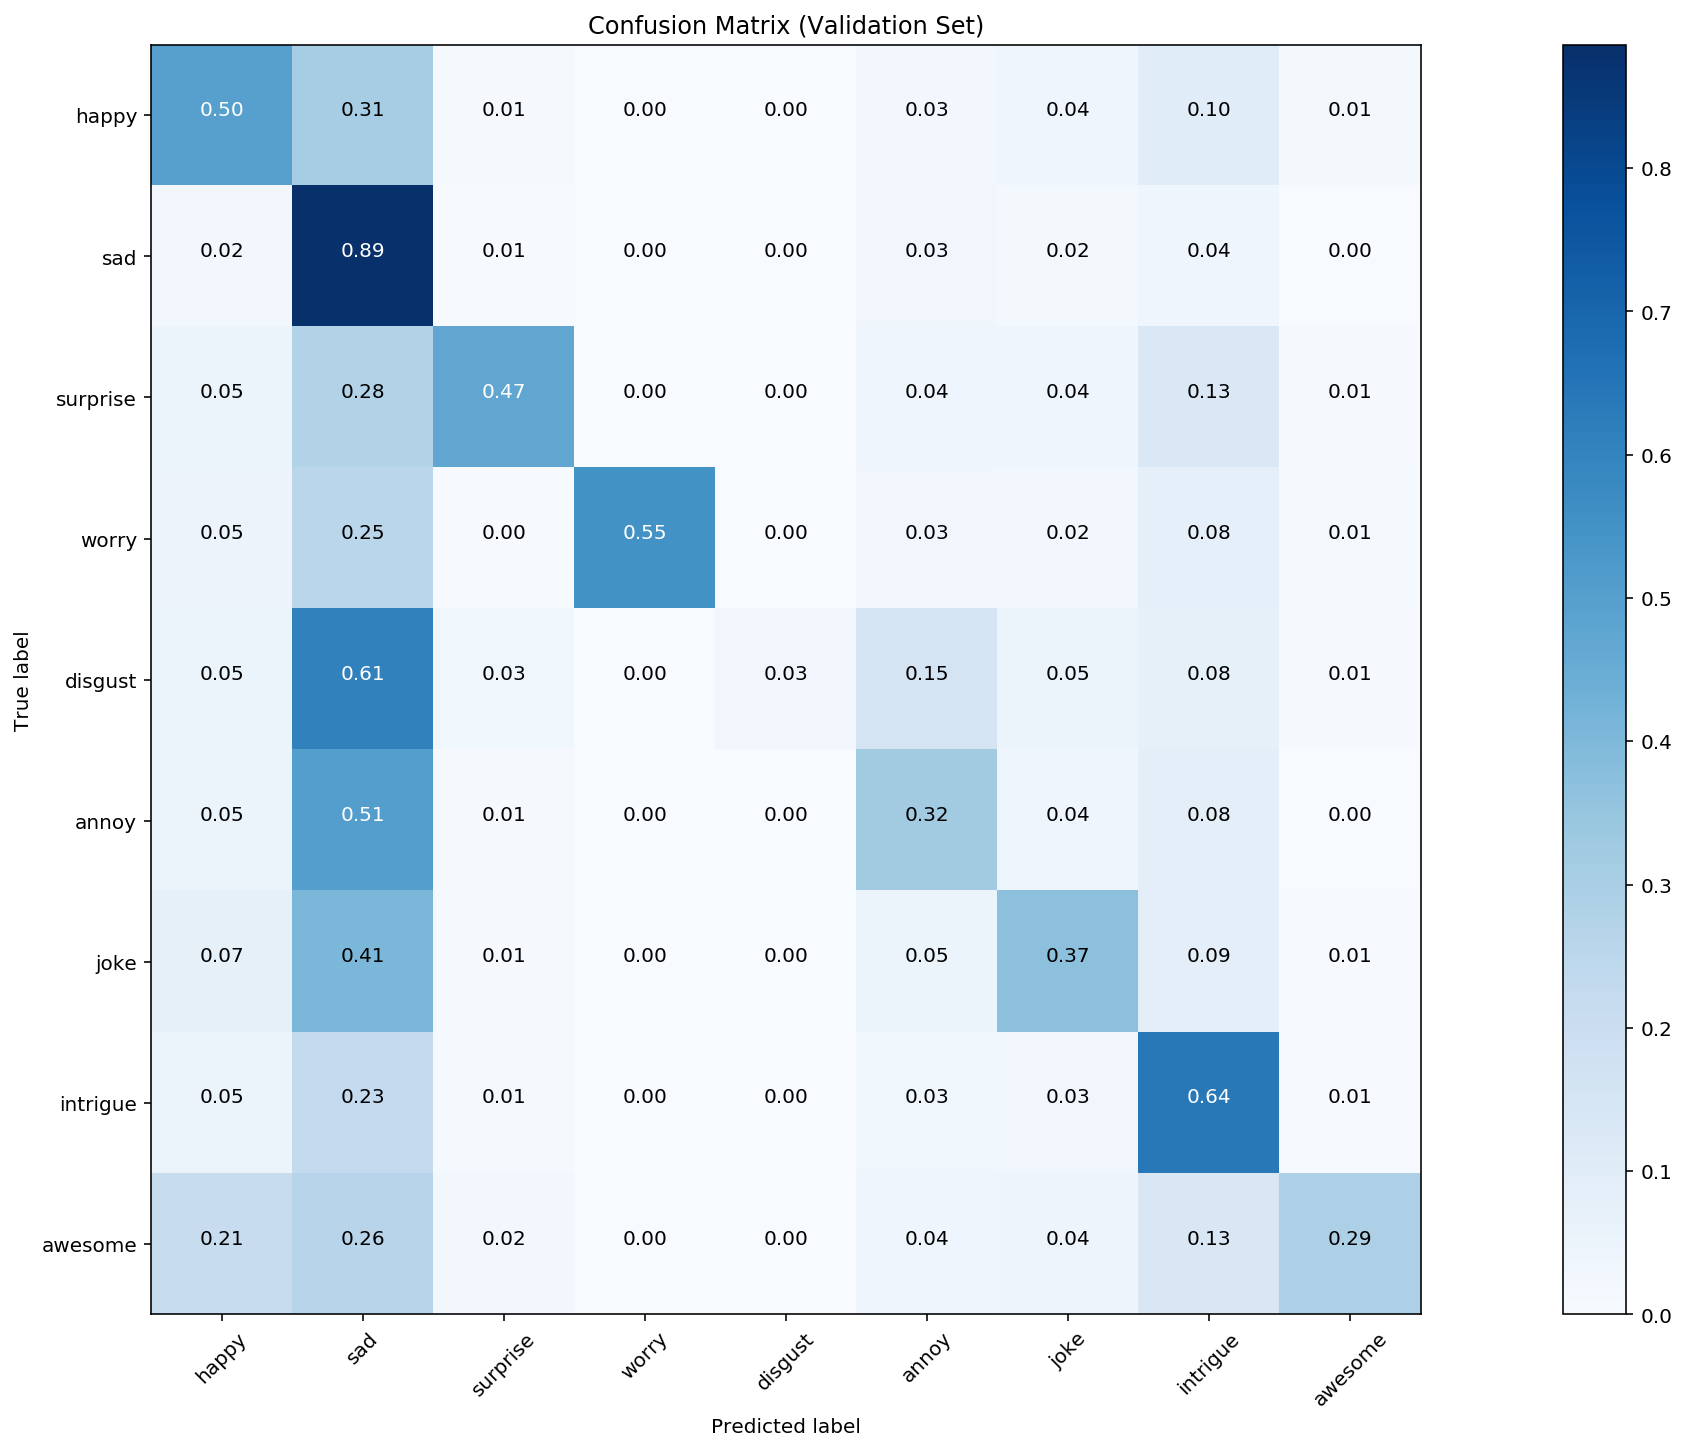

In [20]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)

# precision = true_pos / (true_pos + false_pos)
# recall = true_pos / (true_pos + false_neg)

In [47]:
#text = ["I salute you for the bravery and sacrifice! A true hero indeed.",
#        "I am sorry but I trust HRW I damned sight more than the PAP and it's cronies! Off course the PAP will say that they (HRW) made things up...despite of the fact that SG is a dictator state!?",
#        "PAP are taking the piss again!",
#        "Thought he sold his kidney to buy it; Instead, he bought a kidney then bought the car Filthy rich This is why we need communism",
#        "Somebody needs to water Tharman's head, hair needs to be grown there",
#        "what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen?",
#        "What baby bonus scheme ??? To grow up a kid in Singapore you think is easy now bo ??? Both parent need to work to grow up a kid until 21 , you think tats easy bo ??? Think la"
#       ]
text = ["oh gosh i have to send an answer so many email in my status like this girl apparently calm",]

In [48]:
from time import time
sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
for n, prediction in enumerate(y_prob):
    st = time()
    pred = y_prob.argmax(axis=-1)[n]
    ed = time()
    
    print(text[n],"\nPrediction:",classes[pred], " | ", pred,", time: ", ed-st,"\n")

oh gosh i have to send an answer so many email in my status like this girl apparently calm 
Prediction: sad  |  1 , time:  1.5974044799804688e-05 



In [42]:
np.array(sequences_test[0])

array([ 42,   9, 143, 146,  80,   5, 158,  15,  87,   1,  92,  13, 131])